<a href="https://colab.research.google.com/github/itsalanthomas/shipping-optimization/blob/dev/src/Ecommerice_Optimization_XGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving ecommerce_shipping_cleaned.csv to ecommerce_shipping_cleaned (9).csv


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:02:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy before tuning: 0.66

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.64      0.61       895
           1       0.73      0.67      0.70      1305

    accuracy                           0.66      2200
   macro avg       0.65      0.66      0.65      2200
weighted avg       0.67      0.66      0.66      2200

Confusion Matrix:
 [[577 318]
 [434 871]]
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:02:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters: {'colsample_bytree': np.float64(0.9779976597381381), 'learning_rate': np.float64(0.1554543991712842), 'max_depth': 6, 'n_estimators': 289, 'reg_alpha': np.float64(0.32533033076326434), 'reg_lambda': np.float64(1.9433864484474102), 'subsample': np.float64(0.7814047095321688)}
Accuracy after tuning: 0.66

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.65      0.61       895
           1       0.74      0.67      0.70      1305

    accuracy                           0.66      2200
   macro avg       0.65      0.66      0.66      2200
weighted avg       0.67      0.66      0.66      2200

Confusion Matrix:
 [[580 315]
 [430 875]]


<ipython-input-10-6a03a9c6e748>:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(10), x='Gain', y='Feature', palette='rocket', ax=axes[0])
<ipython-input-10-6a03a9c6e748>:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(10), x='Weight', y='Feature', palette='crest', ax=axes[1])


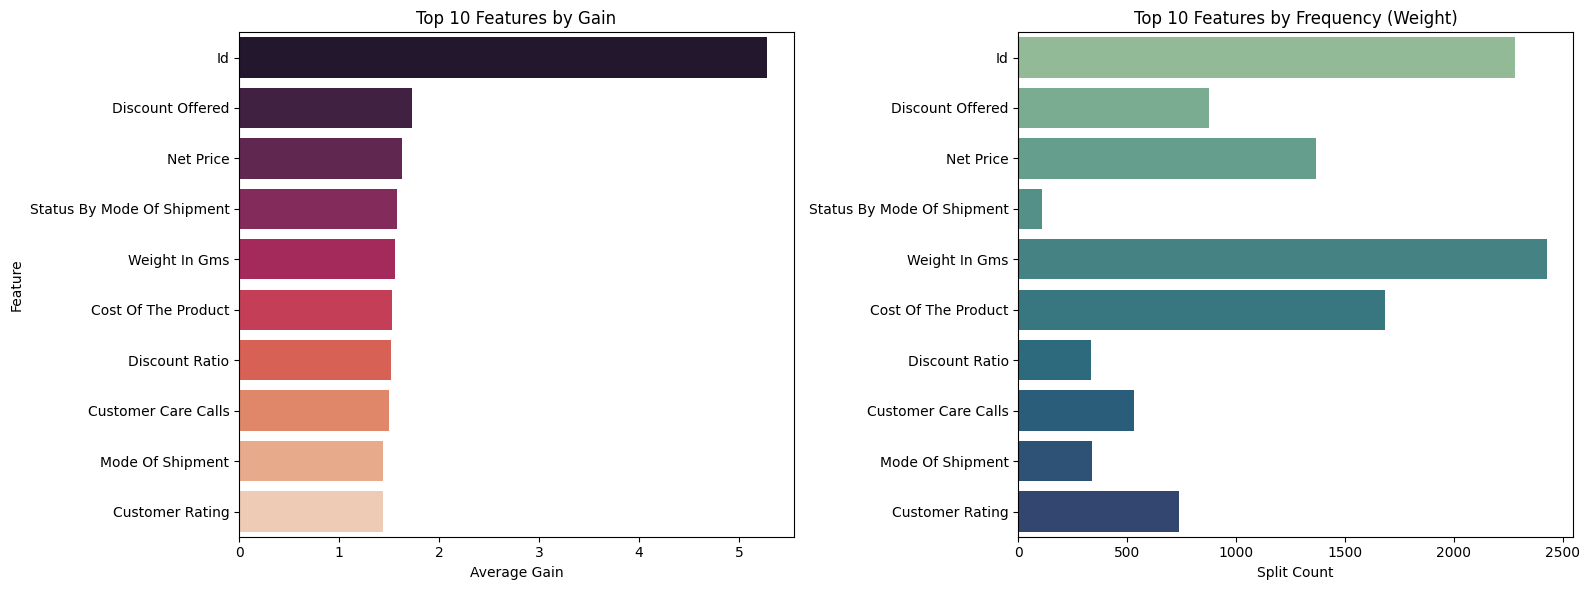

In [10]:
# load libraries
from google.colab import files
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# upload and read the file
uploaded = files.upload()
filename = 'ecommerce_shipping_cleaned.csv'

with open(filename, 'r') as file:
    csv_text = file.read()

df = pd.read_csv(StringIO(csv_text))

# label encode is fine since XGBoost not sensitive to ordinalality
label_cols = ['Warehouse Block', 'Mode Of Shipment', 'Gender']
for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# drop columns not needed in the model
df.drop(columns=['ID'], inplace=True, errors='ignore')

# define features and target
X = df.drop(columns=['On-Time Delivery'])
y = df['On-Time Delivery']

# train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# initialize and train XGBoost Classifier
model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_xgb.fit(X_train, y_train)

# prediction and evaluation
y_pred = model_xgb.predict(X_test)

print('Accuracy before tuning:', round(accuracy_score(y_test, y_pred), 2))
print('\nClassification Report:\n', classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

# base model
xgb_base = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# hyperparameter distributions
param_dist = {
    'n_estimators': randint(100, 300),             # number of boosting rounds
    'max_depth': randint(3, 8),                    # depth of each tree
    'learning_rate': uniform(0.01, 0.2),           # learning rate between 0.01 and 0.21
    'subsample': uniform(0.7, 0.3),                # values from 0.7 to 1.0
    'colsample_bytree': uniform(0.7, 0.3),         # values from 0.7 to 1.0
    'reg_lambda': uniform(0, 5),                   # L2 regularization
    'reg_alpha': uniform(0, 1)                     # L1 regularization
}

# randomized search setup
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# fit on training data
random_search.fit(X_train, y_train)

# best model
best_xgb = random_search.best_estimator_

# prediction and evaluation
y_pred = best_xgb.predict(X_test)

# display results
print('Best Hyperparameters:', random_search.best_params_)
print('Accuracy after tuning:', round(accuracy_score(y_test, y_pred), 2))
print('\nClassification Report:\n', classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

# visualize feature importance
# extract importance types
gain = best_xgb.get_booster().get_score(importance_type='gain')
weight = best_xgb.get_booster().get_score(importance_type='weight')

# convert to df
gain_df = pd.DataFrame(gain.items(), columns=['Feature', 'Gain'])
weight_df = pd.DataFrame(weight.items(), columns=['Feature', 'Weight'])

# merge on feature
importance_df = pd.merge(gain_df, weight_df, on='Feature', how='outer').fillna(0)

# sort by gain
importance_df.sort_values(by='Gain', ascending=False, inplace=True)

# side-by-side visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# gain plot
sns.barplot(data=importance_df.head(10), x='Gain', y='Feature', palette='rocket', ax=axes[0])
axes[0].set_title('Top 10 Features by Gain')
axes[0].set_xlabel('Average Gain')
axes[0].set_ylabel('Feature')

# weight plot
sns.barplot(data=importance_df.head(10), x='Weight', y='Feature', palette='crest', ax=axes[1])
axes[1].set_title('Top 10 Features by Frequency (Weight)')
axes[1].set_xlabel('Split Count')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

